In [1]:
import sys
import os
import subprocess
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display
import cv2
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras import regularizers
%matplotlib inline

Using TensorFlow backend.


In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("/Users/sunchenxi/Desktop/lab/kaggle/amazon/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [3]:
#读取train set标签
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

In [4]:
labels_df.values[8202]

array(['train_8202', 'agriculture clear cultivation primary', 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [5]:
#获取含有tags标签的n张图片
def sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types): #tag是否是string类型
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 1
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]
#获取不含含有tags标签的n张图片
def not_sample_images(tags, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types): #tag是否是string类型
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == 0
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.tif vs. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            print('Found image {}'.format(path))
            return io.imread(path)
    print('Load failed: could not find image {}'.format(path))
 
 #将图片在数组中的位置变成名称
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.get_value(sample_df.index[row_idx], 'image_name')
    return '{}.{}'.format(fname, suffix)

### 获取含有road的图片,变成三通道

In [6]:
n=0
for i in range(len(labels_df)):
    if(labels_df['road'][i]==1):
        n=n+1
fname=[0]*n
s = sample_images(['road'], n=n)
for i in range(n):
    fname[i]= sample_to_fname(s, i)#获得了文件名
road_img=[mpimg.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname[:300]]

In [7]:
fname

['train_23248.jpg',
 'train_26618.jpg',
 'train_24910.jpg',
 'train_35981.jpg',
 'train_12521.jpg',
 'train_826.jpg',
 'train_4113.jpg',
 'train_16856.jpg',
 'train_39818.jpg',
 'train_35774.jpg',
 'train_38354.jpg',
 'train_27720.jpg',
 'train_13773.jpg',
 'train_28691.jpg',
 'train_762.jpg',
 'train_7810.jpg',
 'train_29184.jpg',
 'train_35400.jpg',
 'train_14844.jpg',
 'train_16849.jpg',
 'train_17850.jpg',
 'train_6877.jpg',
 'train_29238.jpg',
 'train_3828.jpg',
 'train_10704.jpg',
 'train_2220.jpg',
 'train_39466.jpg',
 'train_15101.jpg',
 'train_25690.jpg',
 'train_12942.jpg',
 'train_31063.jpg',
 'train_25354.jpg',
 'train_2246.jpg',
 'train_32692.jpg',
 'train_35352.jpg',
 'train_25532.jpg',
 'train_17563.jpg',
 'train_3198.jpg',
 'train_15627.jpg',
 'train_33884.jpg',
 'train_2330.jpg',
 'train_39535.jpg',
 'train_37596.jpg',
 'train_24844.jpg',
 'train_22024.jpg',
 'train_34578.jpg',
 'train_202.jpg',
 'train_17408.jpg',
 'train_683.jpg',
 'train_35306.jpg',
 'train_37482.jp

In [8]:
road_img3=[]
for i in range(len(road_img)):
    for j in range (len(road_img[i])):
        for k in range(len(road_img[i][j])):
            road_img2=road_img[i][j][k][:3]
            road_img3.append(road_img2)
road_img3=np.asarray(road_img3).reshape(300,256,256,3)

In [9]:
road_img3

array([[[[113, 120, 106],
         [115, 114, 108],
         [115, 111, 105],
         ..., 
         [ 65,  78,  73],
         [ 63,  74,  71],
         [ 63,  73,  70]],

        [[103, 116, 102],
         [105, 110, 103],
         [104, 107, 100],
         ..., 
         [ 66,  78,  73],
         [ 63,  73,  71],
         [ 63,  72,  70]],

        [[ 99, 111,  96],
         [ 99, 106,  97],
         [ 98, 103,  94],
         ..., 
         [ 66,  77,  72],
         [ 62,  72,  70],
         [ 62,  71,  69]],

        ..., 
        [[ 75,  85,  75],
         [ 69,  83,  72],
         [ 66,  81,  73],
         ..., 
         [117, 120, 104],
         [114, 119, 103],
         [110, 117, 101]],

        [[ 76,  85,  74],
         [ 71,  84,  73],
         [ 71,  84,  75],
         ..., 
         [120, 123, 106],
         [116, 122, 104],
         [112, 120, 102]],

        [[ 78,  85,  74],
         [ 74,  85,  74],
         [ 75,  87,  77],
         ..., 
         [122, 126, 108],
  

### 获取不含road的图片

In [10]:
n=0
for i in range(len(labels_df)):
    if(labels_df['road'][i]==0):
        n=n+1
fname_not=[0]*n
s = not_sample_images(['road'], n=n)
for i in range(n):
    fname_not[i]= sample_to_fname(s, i)#获得了文件名
not_road_img=[mpimg.imread(PLANET_KAGGLE_ROOT+'/train-jpg/'+ img) for img in fname_not[:300]]

In [11]:
fname_not

['train_29534.jpg',
 'train_21762.jpg',
 'train_2750.jpg',
 'train_14387.jpg',
 'train_6697.jpg',
 'train_21219.jpg',
 'train_24030.jpg',
 'train_22697.jpg',
 'train_3769.jpg',
 'train_21110.jpg',
 'train_18354.jpg',
 'train_28574.jpg',
 'train_33746.jpg',
 'train_24995.jpg',
 'train_36674.jpg',
 'train_36574.jpg',
 'train_18803.jpg',
 'train_8142.jpg',
 'train_38092.jpg',
 'train_10852.jpg',
 'train_25577.jpg',
 'train_16614.jpg',
 'train_24959.jpg',
 'train_16959.jpg',
 'train_10393.jpg',
 'train_38857.jpg',
 'train_32912.jpg',
 'train_18475.jpg',
 'train_10452.jpg',
 'train_33689.jpg',
 'train_9884.jpg',
 'train_3275.jpg',
 'train_21444.jpg',
 'train_1358.jpg',
 'train_33083.jpg',
 'train_25005.jpg',
 'train_37810.jpg',
 'train_1671.jpg',
 'train_4386.jpg',
 'train_20350.jpg',
 'train_23829.jpg',
 'train_21385.jpg',
 'train_30207.jpg',
 'train_17865.jpg',
 'train_22962.jpg',
 'train_34691.jpg',
 'train_14019.jpg',
 'train_18368.jpg',
 'train_18635.jpg',
 'train_14886.jpg',
 'train_9

In [12]:
not_road_img3=[]
for i in range(len(not_road_img)):
    for j in range (len(not_road_img[i])):
        for k in range(len(not_road_img[i][j])):
            not_road_img2=not_road_img[i][j][k][:3]
            not_road_img3.append(not_road_img2)
not_road_img3=np.asarray(not_road_img3).reshape(300,256,256,3)

In [13]:
not_road_img3

array([[[[ 90, 101,  85],
         [ 83,  97,  81],
         [ 75,  93,  77],
         ..., 
         [ 98,  95,  90],
         [ 92,  94,  91],
         [ 85,  92,  91]],

        [[ 88, 100,  86],
         [ 81,  97,  82],
         [ 74,  93,  79],
         ..., 
         [ 95,  96,  91],
         [ 92,  95,  91],
         [ 90,  94,  91]],

        [[ 87,  99,  87],
         [ 81,  96,  85],
         [ 76,  94,  83],
         ..., 
         [ 92,  97,  91],
         [ 94,  97,  91],
         [ 96,  96,  92]],

        ..., 
        [[ 73,  84,  87],
         [ 73,  84,  89],
         [ 73,  85,  90],
         ..., 
         [ 88,  99,  92],
         [ 89,  99,  93],
         [ 86,  99,  94]],

        [[ 67,  81,  84],
         [ 69,  82,  86],
         [ 70,  83,  89],
         ..., 
         [ 92, 101,  93],
         [ 92, 100,  93],
         [ 89,  99,  94]],

        [[ 62,  80,  79],
         [ 65,  81,  82],
         [ 67,  82,  86],
         ..., 
         [ 89,  99,  92],
  

### 训练的图片和标签

#### 一定要用vstack

In [14]:
images=np.vstack((road_img3,not_road_img3))
labels=[1,0]*300+[0,1]*300
resized_images = [np.reshape(cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA), [1,64,64,3]) for img in images]

In [15]:
images

array([[[[113, 120, 106],
         [115, 114, 108],
         [115, 111, 105],
         ..., 
         [ 65,  78,  73],
         [ 63,  74,  71],
         [ 63,  73,  70]],

        [[103, 116, 102],
         [105, 110, 103],
         [104, 107, 100],
         ..., 
         [ 66,  78,  73],
         [ 63,  73,  71],
         [ 63,  72,  70]],

        [[ 99, 111,  96],
         [ 99, 106,  97],
         [ 98, 103,  94],
         ..., 
         [ 66,  77,  72],
         [ 62,  72,  70],
         [ 62,  71,  69]],

        ..., 
        [[ 75,  85,  75],
         [ 69,  83,  72],
         [ 66,  81,  73],
         ..., 
         [117, 120, 104],
         [114, 119, 103],
         [110, 117, 101]],

        [[ 76,  85,  74],
         [ 71,  84,  73],
         [ 71,  84,  75],
         ..., 
         [120, 123, 106],
         [116, 122, 104],
         [112, 120, 102]],

        [[ 78,  85,  74],
         [ 74,  85,  74],
         [ 75,  87,  77],
         ..., 
         [122, 126, 108],
  

In [16]:
resized_images

[array([[[[102, 108,  97],
          [ 91, 100,  89],
          [ 94, 102,  92],
          ..., 
          [ 64,  74,  70],
          [ 64,  75,  72],
          [ 65,  76,  72]],
 
         [[ 93, 102,  88],
          [ 94, 101,  89],
          [ 85,  92,  85],
          ..., 
          [ 64,  74,  70],
          [ 65,  76,  72],
          [ 62,  73,  69]],
 
         [[ 86,  95,  85],
          [ 87,  94,  85],
          [ 81,  90,  82],
          ..., 
          [ 62,  72,  70],
          [ 62,  73,  71],
          [ 63,  75,  73]],
 
         ..., 
         [[ 74,  83,  73],
          [ 84,  92,  81],
          [ 77,  85,  76],
          ..., 
          [139, 141, 122],
          [136, 138, 118],
          [127, 130, 113]],
 
         [[ 79,  89,  78],
          [ 82,  89,  80],
          [ 74,  82,  74],
          ..., 
          [133, 136, 118],
          [132, 135, 117],
          [117, 121, 105]],
 
         [[ 73,  85,  75],
          [ 74,  85,  75],
          [ 71,  82,  75],

In [17]:
train_size = int(len(resized_images)*0.9)
train_x = np.vstack(resized_images[:train_size])
test_x = resized_images[train_size:]
train_y = np.vstack(labels[:train_size])
test_y = labels[train_size:]

In [18]:
len(train_y)

540

In [19]:
len(train_x)

540

### 四通道的图片

In [20]:
img=road_img[:500]+not_road_img[:500]
labels=[1,0]*500+[0,1]*500
resized_images2 = [np.reshape(cv2.resize(img,(64,64),interpolation=cv2.INTER_AREA), [1,64,64,4]) for img in img]
train_size = int(len(resized_images2))
train_x2 = np.vstack(resized_images2[:train_size])
test_x2= resized_images2[train_size:]
train_y2 = np.vstack(labels[:train_size])
test_y2 = labels[train_size:]

In [21]:
op = RMSprop(lr=0.0001)
ob = 'binary_crossentropy'
def Cnet():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(64, 64, 3), activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Convolution2D(64, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    

    
    model.add(Convolution2D(128, 4, 4, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    

    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))
    
    model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.3)))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss=ob, optimizer=op, metrics=['accuracy'])
    return model


model = Cnet()


model = Cnet()
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

history = LossHistory()
model.fit(train_x, train_y, batch_size=32, epochs=80,validation_split=0.25, verbose=1, shuffle=True, callbacks=[history])

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(64, 64, 3...)`
  import sys
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
  
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), padding="same", activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (4, 4), padding="same", activation="relu")`
  app.launch_new_instance()


Train on 405 samples, validate on 135 samples
Epoch 1/80
405/405 [==============================] - 27s - loss: 176.6044 - acc: 0.4790 - val_loss: 171.2827 - val_acc: 0.5037
Epoch 2/80
405/405 [==============================] - 22s - loss: 168.4842 - acc: 0.5086 - val_loss: 165.0790 - val_acc: 0.5037
Epoch 3/80
405/405 [==============================] - 20s - loss: 162.3485 - acc: 0.5160 - val_loss: 158.9558 - val_acc: 0.4815
Epoch 4/80
405/405 [==============================] - 20s - loss: 156.3043 - acc: 0.5358 - val_loss: 153.1627 - val_acc: 0.5037
Epoch 5/80
405/405 [==============================] - 20s - loss: 150.4549 - acc: 0.4963 - val_loss: 147.2154 - val_acc: 0.4741
Epoch 6/80
405/405 [==============================] - 20s - loss: 144.5987 - acc: 0.5580 - val_loss: 141.6556 - val_acc: 0.4963
Epoch 7/80
405/405 [==============================] - 20s - loss: 138.9298 - acc: 0.5506 - val_loss: 135.9084 - val_acc: 0.4963
Epoch 8/80
405/405 [==============================] - 20s 

405/405 [==============================] - 8s - loss: 3.3455 - acc: 0.8741 - val_loss: 3.6085 - val_acc: 0.5037
Epoch 66/80
405/405 [==============================] - 8s - loss: 3.0451 - acc: 0.9259 - val_loss: 3.3884 - val_acc: 0.5111
Epoch 67/80
405/405 [==============================] - 9s - loss: 2.8377 - acc: 0.8790 - val_loss: 3.1730 - val_acc: 0.5185
Epoch 68/80
405/405 [==============================] - 16s - loss: 2.6485 - acc: 0.8667 - val_loss: 2.9635 - val_acc: 0.5185
Epoch 69/80
405/405 [==============================] - 10s - loss: 2.4224 - acc: 0.9086 - val_loss: 2.8501 - val_acc: 0.5333
Epoch 70/80
405/405 [==============================] - 8s - loss: 2.2748 - acc: 0.8864 - val_loss: 2.7747 - val_acc: 0.4667
Epoch 71/80
405/405 [==============================] - 11s - loss: 2.0789 - acc: 0.9185 - val_loss: 2.6347 - val_acc: 0.5481
Epoch 72/80
405/405 [==============================] - 11s - loss: 1.9799 - acc: 0.9012 - val_loss: 2.5169 - val_acc: 0.4889
Epoch 73/80
405/

In [22]:
score = model.evaluate(train_x, train_y, verbose=0)  
print('Test score:', score[0])  
print('Test accuracy:', score[1])  

('Test score:', 1.3653908579437821)
('Test accuracy:', 0.80370370304142991)


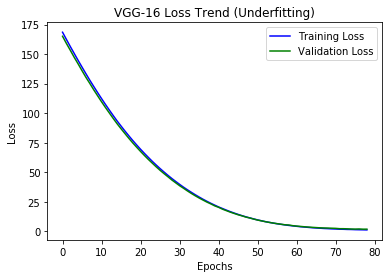

In [23]:
loss = history.losses
val_loss = history.val_losses
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend (Underfitting)')
plt.plot(loss[1:], 'blue', label='Training Loss')
plt.plot(val_loss[1:], 'green', label='Validation Loss')
plt.legend()
plt.show()

In [24]:
n=0
for i in range(0,300):
    a=model.predict(resized_images[i])
    print a
    if(a>0.5):
        n+=1  
n2=0
for i in range(300,600):
    a=model.predict(resized_images[i])
    print a
    if(a<0.5):
        n2+=1 
acc=(float)(n+n2)/600

[[ 0.98911577]]
[[ 0.39430097]]
[[ 0.9797982]]
[[ 0.10989418]]
[[ 0.99926728]]
[[ 0.03947322]]
[[ 0.92943394]]
[[ 0.17344204]]
[[ 0.99245024]]
[[ 0.03283112]]
[[ 0.93082595]]
[[ 0.58687472]]
[[ 0.91613787]]
[[ 0.00595163]]
[[ 0.98764622]]
[[ 0.10247168]]
[[ 0.96261311]]
[[ 0.05396739]]
[[ 0.96547401]]
[[ 0.27810138]]
[[ 0.98189193]]
[[ 0.18680058]]
[[ 0.96458721]]
[[ 0.04789457]]
[[ 0.80537927]]
[[ 0.00515102]]
[[ 0.99137938]]
[[ 0.27342018]]
[[ 0.8734746]]
[[ 0.25891206]]
[[ 0.96321064]]
[[ 0.42305675]]
[[ 0.97577786]]
[[ 0.51860678]]
[[ 0.96901578]]
[[ 0.27121046]]
[[ 0.99468094]]
[[ 0.08131981]]
[[ 0.94159937]]
[[ 0.07446869]]
[[ 0.97235739]]
[[ 0.15155415]]
[[ 0.99094218]]
[[ 0.0725452]]
[[ 0.98237818]]
[[ 0.02487222]]
[[ 0.99551624]]
[[ 0.25598109]]
[[ 0.96625096]]
[[ 0.02166401]]
[[ 0.99612266]]
[[ 0.0231651]]
[[ 0.93185127]]
[[ 0.32338533]]
[[ 0.99767405]]
[[ 0.36136031]]
[[ 0.96084279]]
[[ 0.09295554]]
[[ 0.96799558]]
[[ 0.04375928]]
[[ 0.83666939]]
[[ 0.18416955]]
[[ 0.9916486

[[ 0.77683359]]
[[ 0.45627838]]
[[ 0.85910547]]
[[ 0.91023159]]
[[ 0.79701823]]
[[ 0.24544723]]
[[ 0.77441525]]
[[ 0.8392328]]
[[ 0.42766395]]
[[ 0.57576513]]
[[ 0.21214323]]
[[ 0.68379325]]
[[ 0.67291307]]
[[ 0.64447492]]
[[ 0.63236821]]
[[ 0.87166333]]
[[ 0.68234074]]
[[ 0.89405799]]
[[ 0.52380419]]
[[ 0.64258194]]
[[ 0.81052816]]
[[ 0.42778477]]
[[ 0.74513847]]
[[ 0.8831296]]
[[ 0.76928389]]
[[ 0.38980955]]
[[ 0.83474153]]
[[ 0.86815315]]
[[ 0.83172899]]
[[ 0.90393889]]
[[ 0.58508855]]
[[ 0.54166621]]
[[ 0.71647495]]
[[ 0.66035312]]
[[ 0.65777308]]
[[ 0.95645559]]
[[ 0.85106403]]
[[ 0.53663892]]
[[ 0.81447619]]
[[ 0.86468577]]
[[ 0.50016785]]
[[ 0.35219535]]
[[ 0.9613722]]
[[ 0.8333267]]
[[ 0.30021203]]
[[ 0.37257269]]
[[ 0.52165347]]
[[ 0.61664236]]
[[ 0.86960208]]
[[ 0.61289847]]
[[ 0.83556759]]
[[ 0.62831306]]
[[ 0.82816964]]
[[ 0.90422869]]
[[ 0.4224824]]
[[ 0.73847467]]
[[ 0.63140112]]
[[ 0.57628316]]
[[ 0.72197008]]
[[ 0.61145574]]
[[ 0.10029597]]
[[ 0.15541087]]
[[ 0.58038658

In [25]:
n , n2, acc

(171, 73, 0.4066666666666667)